# Neural-Network Classification Task On "Amazon Employee Access" Dataset:

---

---

In [264]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

In [62]:
df = pd.read_csv('Data/amazon-employee-access-challenge(original)/train.csv')

print("Number of instances with target value 0: ", df[df["ACTION"] == 0]["ACTION"].shape[0])
print("Number of instances with target value 1: ", df[df["ACTION"] == 1]["ACTION"].shape[0])
print("Total Number of instances and features: ", df.shape)


Number of instances with target value 0:  1897
Number of instances with target value 1:  30872
Total Number of instances and features:  (32769, 10)


So we notice that our data is highly imbalenced (only 5.8% are of class 0) and we need to take that into considiration when splitting.

In [63]:
df

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082


In [64]:
f = ['ACTION', 'RESOURCE', 'MGR_ID','ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

In [159]:
# number of unique values per feature
for F in f:
    print(F,": ",df[F].unique().shape[0])

ACTION :  2
RESOURCE :  7518
MGR_ID :  4243
ROLE_ROLLUP_1 :  128
ROLE_ROLLUP_2 :  177
ROLE_DEPTNAME :  449
ROLE_TITLE :  343
ROLE_FAMILY_DESC :  2358
ROLE_FAMILY :  67
ROLE_CODE :  343


## About the process and Data:
As we can see the number of unique instances per feature is huge so We decided to use embeddings instead of one-hot encoding or label encoding. One-hot encoding in this context would result in extremely high-dimensional sparse matrices, making training inefficient and prone to overfitting. In contrast, embeddings allow us to represent each category as a dense, low-dimensional vector that is learned during training, enabling the model to capture similarities between related categories and reducing the input dimensionality significantly.

So the input of the Neural-Net will now be the embeded-vector of the feature value, for each feature, all concatinated.

We will drop those non-predective features:

('RESOURCE', 'MGR_ID')

They are just ID's and don't help to generalize.

In [68]:
data = df.drop(columns=['RESOURCE', 'MGR_ID'])
data

,ACTION,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,117961,118300,123472,117905,117906,290919,117908
1,1,117961,118343,123125,118536,118536,308574,118539
2,1,118219,118220,117884,117879,267952,19721,117880
3,1,117961,118343,119993,118321,240983,290919,118322
4,1,117929,117930,119569,119323,123932,19793,119325
...,...,...,...,...,...,...,...,...
32764,1,117961,118300,119993,118321,240983,290919,118322
32765,1,91261,118026,122392,121143,173805,249618,121145
32766,1,117961,118327,120299,124922,152038,118612,124924
32767,1,118256,118257,117945,280788,280788,292795,119082


In [70]:
X_pd = data.drop(columns=["ACTION"]) # features
y_pd = data["ACTION"] #target feature

print(y_pd.head())
X_pd.head()

0    1
1    1
2    1
3    1
4    1
Name: ACTION, dtype: int64


,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,117961,118300,123472,117905,117906,290919,117908
1,117961,118343,123125,118536,118536,308574,118539
2,118219,118220,117884,117879,267952,19721,117880
3,117961,118343,119993,118321,240983,290919,118322
4,117929,117930,119569,119323,123932,19793,119325


In [74]:
# Data to numpy
X_np = X_pd.to_numpy()
y_np = y_pd.to_numpy()
print(y_np)
X_np

[1 1 1 ... 1 1 1]


array([[117961, 118300, 123472, ..., 117906, 290919, 117908],
       [117961, 118343, 123125, ..., 118536, 308574, 118539],
       [118219, 118220, 117884, ..., 267952,  19721, 117880],
       ...,
       [117961, 118327, 120299, ..., 152038, 118612, 124924],
       [118256, 118257, 117945, ..., 280788, 292795, 119082],
       [117916, 118150, 117920, ..., 122142,  19721, 118570]], dtype=int64)

We need to split our data into "train and validation" sets.

test set is separate.

In [84]:
# split: train + val, stratify to handle class imbalance
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.3, random_state=42, stratify=y_np
)

# Test set:
df2 = pd.read_csv('Data/amazon-employee-access-challenge(original)/test.csv')
X_pd2 =df2.drop(columns=['id','RESOURCE', 'MGR_ID'])
X_test = X_pd2.to_numpy()

In [85]:
print(X_train.shape, X_val.shape, X_test.shape)

(22938, 7) (9831, 7) (58921, 7)


In [86]:
# Transform to tensors:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)

torch.Size([22938, 7]) torch.Size([9831, 7]) torch.Size([58921, 7])


In [90]:
# Transform to tensors:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_train_tensor = y_train_tensor.view([22938,1])

y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_val_tensor = y_val_tensor.view([9831,1])

# no y_test

print(y_train_tensor.shape, y_val_tensor.shape)

torch.Size([22938, 1]) torch.Size([9831, 1])


### Utility Functions and Data mapping:

This Function assign to each unique value in a feature an index and the 0th index is set to 0 to handle unseen values.

We concatinate the train and validation sets to get all possible values for the features.

In [196]:
# The mapping function
def map_values(values):
    rollup1_mapping = {0:torch.tensor(0,dtype=torch.float32)}
    counter = 1
    for val in values:
        if val not in rollup1_mapping:
            rollup1_mapping[val.item()] = torch.tensor(counter,dtype=torch.float32) 
            counter += 1
    return rollup1_mapping


In [197]:
map_rollup1 = map_values(torch.cat([X_train_tensor[:, 0], X_val_tensor[:, 0]], dim=0).unique())
map_rollup2 = map_values(torch.cat([X_train_tensor[:, 1], X_val_tensor[:, 1]], dim=0).unique())
map_dept = map_values(torch.cat([X_train_tensor[:, 2], X_val_tensor[:, 2]], dim=0).unique())
map_title = map_values(torch.cat([X_train_tensor[:, 3], X_val_tensor[:, 3]], dim=0).unique())
map_famdesc = map_values(torch.cat([X_train_tensor[:, 4], X_val_tensor[:, 4]], dim=0).unique())
map_family = map_values(torch.cat([X_train_tensor[:, 5], X_val_tensor[:, 5]], dim=0).unique())
map_rolecode = map_values(torch.cat([X_train_tensor[:, 6], X_val_tensor[:, 6]], dim=0).unique())

In [218]:
maps = [map_rollup1, map_rollup2, map_dept, map_title, map_famdesc, map_family, map_rolecode]

These are the unique values in our train data set, plus the length.

In [207]:
map_family

{0: tensor(0.),
 3130.0: tensor(1.),
 4673.0: tensor(2.),
 6725.0: tensor(3.),
 19721.0: tensor(4.),
 19793.0: tensor(5.),
 117887.0: tensor(6.),
 118131.0: tensor(7.),
 118205.0: tensor(8.),
 118295.0: tensor(9.),
 118331.0: tensor(10.),
 118347.0: tensor(11.),
 118363.0: tensor(12.),
 118372.0: tensor(13.),
 118398.0: tensor(14.),
 118424.0: tensor(15.),
 118453.0: tensor(16.),
 118467.0: tensor(17.),
 118474.0: tensor(18.),
 118478.0: tensor(19.),
 118504.0: tensor(20.),
 118612.0: tensor(21.),
 118638.0: tensor(22.),
 118643.0: tensor(23.),
 118667.0: tensor(24.),
 118704.0: tensor(25.),
 118736.0: tensor(26.),
 118762.0: tensor(27.),
 118870.0: tensor(28.),
 118960.0: tensor(29.),
 119006.0: tensor(30.),
 119095.0: tensor(31.),
 119184.0: tensor(32.),
 119221.0: tensor(33.),
 119695.0: tensor(34.),
 119772.0: tensor(35.),
 119784.0: tensor(36.),
 119788.0: tensor(37.),
 120134.0: tensor(38.),
 120302.0: tensor(39.),
 120518.0: tensor(40.),
 121069.0: tensor(41.),
 121620.0: tensor

In [162]:
#Num distinct values + 1
print(len(map_rollup1),len(map_rollup2),len(map_dept),len(map_title),
      len(map_famdesc),len(map_family),len(map_rolecode))

129 178 450 344 2359 68 344


In [156]:
def valueToIndex(value, maped_values):
    idx = maped_values.get(value, 0)
    return idx

In [276]:
import pickle

def save_model_params(model, model_name):
    # Extract the state_dict of the model (weights and biases)
    model_params = model.state_dict()

    # Specify the filename for the pickle file
    filename = f"{model_name}_params.pkl"

    # Save the parameters to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(model_params, f)

    print(f"Model parameters saved to {filename}")

### Neural-Net Architecture and Creation:

We will train a Neural-Net to both do the embedding and predict the class, the embedding vector size will depend on the number of unique instances in each feature and we can use the rule of thumb min(50, dist_vals/2) or less.

so we get the vectors of sizes:

ROLE_ROLLUP_1    50

ROLE_ROLLUP_2	 50

ROLE_DEPTNAME	 50

ROLE_TITLE   	 50

ROLE_FAMILY_DESC 100

ROLE_FAMILY	     34

ROLE_CODE	     50

- Total of 384 inputs.

#### We will try an architecture of:

- Input: 384

- Hidden Layer 1: 192

- Hidden Layer 2: 96

- Hidden Layer 3: 48

- Output: 1 (for binary classification)

- And use "BCE" (Binary Cross-Entropy) loss function.

- Using the ReLU activation function.

In [ ]:
class NeuralClassifier(nn.Module): # one hidden layer

    def __init__(self):
        super().__init__()
        self.mappedX = []
        
        # Embedding layers (vocab_size, embedding_dim)
        # +1 in dim for any unseen values to be mapped to 0
        self.embed_rollup1 = nn.Embedding(128 + 1, 50)
        self.embed_rollup2 = nn.Embedding(177 + 1, 50)
        self.embed_dept = nn.Embedding(449 + 1, 50)
        self.embed_title = nn.Embedding(343 + 1, 50)
        self.embed_famdesc = nn.Embedding(2358 + 1, 100)
        self.embed_family = nn.Embedding(67 + 1, 34)
        self.embed_rolecode = nn.Embedding(343 + 1, 50)

        # Total embedding output size = sum of all embedding dims
        embedding_output_size = 384

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_output_size, 192)
        self.fc2 = nn.Linear(192, 96)
        self.fc3 = nn.Linear(96, 48)
        self.fc4 = nn.Linear(48, 1)  # Binary classification

    def getMappings(self, X): #gets the train dataset and returns the indices used by the embed function
        X = X.T
        output = []
        i=0
        for x in X:
            temp_list = [valueToIndex(element.item(), maps[i]) for element in x]
            temp_list_tensor = torch.tensor(temp_list).long()
            output.append(temp_list_tensor)
            i+=1
        self.mappedX = output
        return output

    def forward(self, x):
        # Unpack categorical columns (assumes tensor of shape [B, 7])
        r1, r2, dept, title, famdesc, fam, rolecode = self.mappedX

        # Embed and concatenate
        emb = torch.cat([
            self.embed_rollup1(r1),
            self.embed_rollup2(r2),
            self.embed_dept(dept),
            self.embed_title(title),
            self.embed_famdesc(famdesc),
            self.embed_family(fam),
            self.embed_rolecode(rolecode)
        ], dim=1)

        # Feedforward
        x = F.relu(self.fc1(emb))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Raw logits
        return x

In [273]:
def Predict(rawLogits): #takes raw logits and outputs classes
    x = (rawLogits > 0).long()
    return x

### Fitting

In [230]:
# the fit function:
def fit(model, trainX_tensor, trainY_tensor, optimizer, loss_fn, iterations = 1000): #model must have called getMappings()
    losses = []
    for i in range(iterations):

        output = model.forward(trainX_tensor)

        loss = loss_fn(output, trainY_tensor)

        optimizer.zero_grad() # reset gradients
        loss.backward()
        optimizer.step()

        if(i%200==0):
            print("current loss: ", loss)
            losses.append(loss)
    return losses

In [247]:
# initializations
Model = NeuralClassifier()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss() # no activation function applied to the output

In [248]:
Model.getMappings(X_train_tensor) # saved in model.mappedX

[tensor([22, 31, 22,  ..., 22, 61, 22]),
 tensor([65, 32, 65,  ..., 65, 52, 65]),
 tensor([ 47,  24, 140,  ...,  63,  42, 370]),
 tensor([13,  1,  5,  ..., 93, 29, 53]),
 tensor([ 239,    5,    8,  ..., 2347,  600, 1868]),
 tensor([ 7,  4, 65,  ..., 15, 16, 15]),
 tensor([ 13,   1,   5,  ..., 101,  30,  57])]

In [252]:
loses = fit(Model,X_train_tensor,y_train_tensor,optimizer,loss_fn)

current loss:  tensor(0.6870, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
current loss:  tensor(0.0874, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
current loss:  tensor(0.0873, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
current loss:  tensor(0.0873, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
current loss:  tensor(0.0873, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [280]:
def plot_loss_curves(loss_lists, labels=None, title="Loss over Iterations", interval=200):
    """
    Plots loss values from multiple training runs.

    Args:
        loss_lists (list of list of tensors): Lists of losses (e.g., [[loss1, loss2], [loss3, loss4], ...])
        labels (list of str): Optional labels for each loss curve.
        title (str): Plot title.
        interval (int): Interval of iterations between recorded loss points.
    """
    plt.figure(figsize=(10, 5))

    for i, loss_list in enumerate(loss_lists):
        # Convert tensors to floats
        losses = [float(l.detach().cpu()) for l in loss_list]
        iters = [i * interval for i in range(len(losses))]
        
        label = labels[i] if labels else f"Model {i+1}"
        plt.plot(iters, losses, label=label)

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


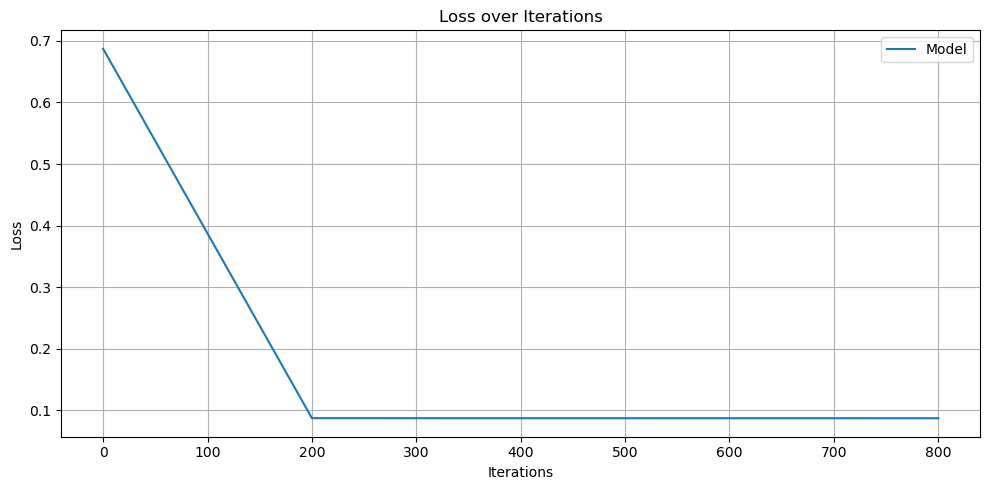

In [281]:
plot_loss_curves([loses],["Model"])

### Validation:

In [266]:
Model.getMappings(X_val_tensor) # to take the mappings of the validation set

[tensor([22, 22, 22,  ..., 13, 22, 22]),
 tensor([67, 22, 65,  ..., 11, 69, 72]),
 tensor([113,  46,  11,  ...,  15, 411, 209]),
 tensor([120,   5,   5,  ...,   2,  23, 121]),
 tensor([2339,    8,    8,  ...,    9,   55,  500]),
 tensor([14, 65, 65,  ...,  6, 65, 65]),
 tensor([129,   5,   5,  ...,   2,  24, 130])]

In [267]:
out = Model.forward(X_val_tensor)

In [269]:
out #raw logits

tensor([[ 9.4511],
        [ 3.9682],
        [22.1897],
        ...,
        [15.1398],
        [25.1479],
        [47.5186]], grad_fn=<AddmmBackward0>)

In [292]:
y_pred = Predict(out)
y_pred # classes

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [293]:
f1_score(y_val_tensor,y_pred)

0.9688102893890675

In [301]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve
)

def plot_classification_results(y_true, y_pred_labels, y_pred_scores):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title('Confusion Matrix')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_scores)
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve')
    axs[1].legend()
    axs[1].grid()

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_scores)
    axs[2].plot(recall, precision, marker='.')
    axs[2].set_xlabel('Recall')
    axs[2].set_ylabel('Precision')
    axs[2].set_title('Precision-Recall Curve')
    axs[2].grid()

    plt.tight_layout()
    plt.show()

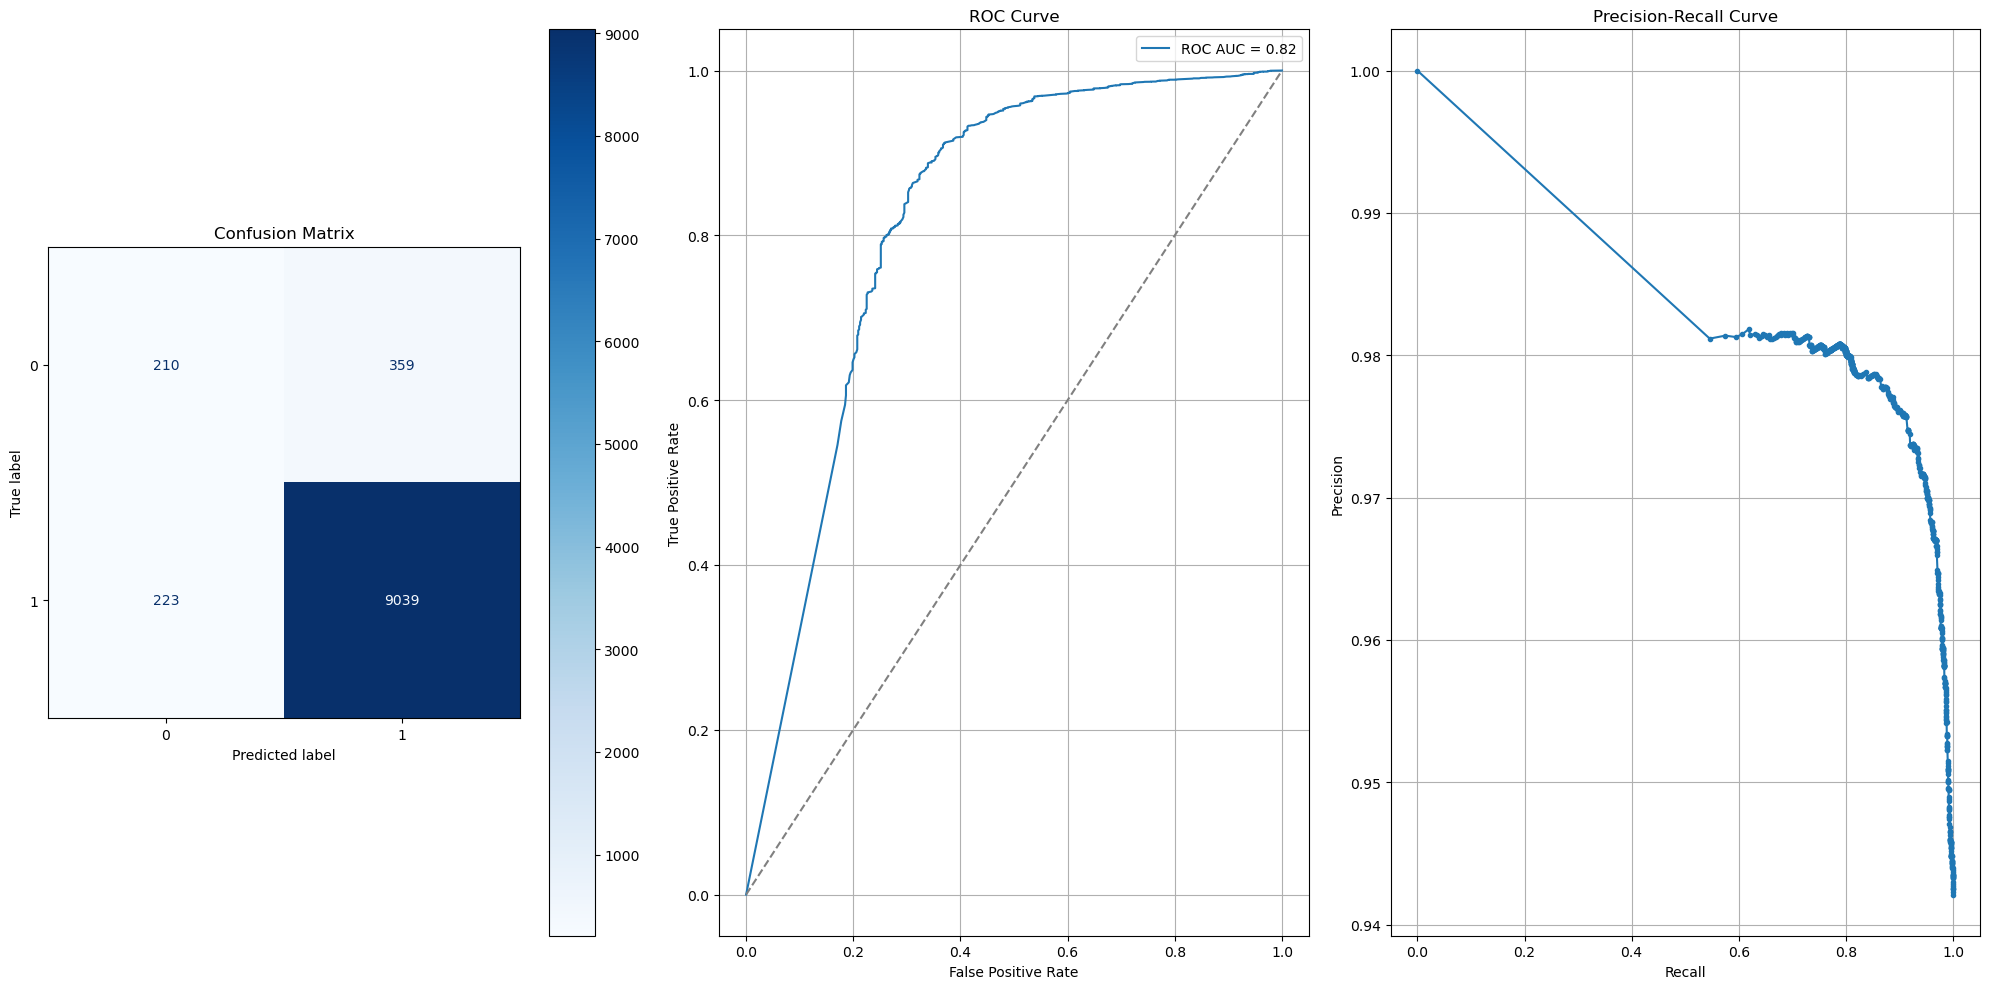

In [302]:
y_scores = torch.sigmoid(out).detach().numpy().flatten()

plot_classification_results(y_val_tensor,y_pred, y_scores)

So using f1_score (classes are unbalanced) we get an accuracy of 97%, which is very good.

and the plots show very good results.

In [277]:
save_model_params(Model, "NeuralClassifier")

Model parameters saved to NeuralClassifier_params.pkl


## Testing

In [309]:
Model.getMappings(X_test_tensor)

[tensor([34, 22, 22,  ..., 22, 22, 22]),
 tensor([39, 67, 65,  ..., 69, 67, 69]),
 tensor([ 14,  70, 154,  ...,   4, 205,  90]),
 tensor([ 1, 56, 14,  ..., 20, 23, 76]),
 tensor([  33,  233, 2251,  ...,   40,    8,  740]),
 tensor([ 4, 14, 62,  ..., 65, 65, 15]),
 tensor([ 1, 60, 14,  ..., 21, 24, 83])]

In [311]:
out_test = Model.forward(X_test_tensor) #Raw logits

In [312]:
Predict(out_test)

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])